In [1]:
#Importing the matrix exponentiation function
from scipy.linalg import expm, logm
#Importing constants
import scipy.constants as const
#Numpy
import numpy as np
#Plotting
import matplotlib
import matplotlib.pyplot as plt
#!pip install ipympl # Needed for Google Colab
#%matplotlib widget
#from google.colab import output # Needed for Google Colab
#output.enable_custom_widget_manager() # Needed for Google Colab

#Method for calculating partial trace
## https://www.peijun.me/reduced-density-matrix-and-partial-trace.html

c:\Users\conor\anaconda3\lib\site-packages\scipy\linalg\_matfuncs_inv_ssq.py:827: LogmExactlySingularWarning: The logm input matrix is exactly singular.
  warnings.warn(exact_singularity_msg, LogmExactlySingularWarning)
c:\Users\conor\anaconda3\lib\site-packages\scipy\linalg\_matfuncs_inv_ssq.py:836: LogmNearlySingularWarning: The logm input matrix may be nearly singular.
  warnings.warn(near_singularity_msg, LogmNearlySingularWarning)
c:\Users\conor\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


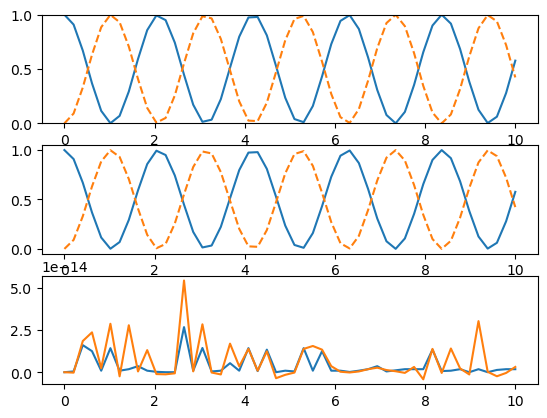

In [2]:
#Evolution of 4 basis states for 2 independent systems
n1 = 2
n2 = 2

reduced_density_matrix_a = lambda rho_tensor: np.trace(rho_tensor, axis1=1, axis2=3) #rho_a
reduced_density_matrix_b = lambda rho_tensor: np.trace(rho_tensor, axis1=0, axis2=2) #rho_b

#diagonal (c_00 + c_01)

#Let's define some useful matrices
hadamard = (1/np.sqrt(2))*np.array([[1, 1],[1, -1]])
identity = np.array([[1, 0],[0, 1]])

#Let's take the following two Hamiltonians for two independent qubits
hamiltonian_a = np.array([[0, 1.5],[1.5, 0]])
hamiltonian_b = np.array([[0, 1.5],[1.5, 0]])
eig_values_a, eig_vectors_a = np.linalg.eig(hamiltonian_a)
eig_values_b, eig_vectors_b = np.linalg.eig(hamiltonian_b)
#Now form the kronecker product
hamiltonian_total_indep = np.kron(hamiltonian_a, identity) + np.kron(identity, hamiltonian_b)

#What are the initial states for each system? arr = arr[..., None]
initial_state_a = np.matmul(identity, np.array([[1],[0]]))#eig_vectors_a[:,0].reshape(-1,1))
initial_state_b = np.matmul(identity, np.array([[1],[0]]))#eig_vectors_b[:,0].reshape(-1,1))
#Initial state in combined system
initial_state_total = np.kron(initial_state_a, initial_state_b)

#Define the evolution operator function with hbar = 1
def evolutionOperator(hamiltonian, time):
  return expm(-1j*hamiltonian*time)

#Probability of measuring each state
projector_00 = np.array([[1,0,0,0]])
projector_01 = np.array([[0,1,0,0]])
projector_10 = np.array([[0,0,1,0]])
projector_11 = np.array([[0,0,0,1]])
prob_measure_0_a = lambda state: np.abs(np.matmul(projector_00, state)[0][0])**2 + np.abs(np.matmul(projector_01, state)[0][0])**2
prob_measure_1_a = lambda state: np.abs(np.matmul(projector_10, state)[0][0])**2 + np.abs(np.matmul(projector_11, state)[0][0])**2
prob_measure_0_b = lambda state: np.abs(np.matmul(projector_00, state)[0][0])**2 + np.abs(np.matmul(projector_10, state)[0][0])**2
prob_measure_1_b = lambda state: np.abs(np.matmul(projector_01, state)[0][0])**2 + np.abs(np.matmul(projector_11, state)[0][0])**2

#Von Neumann Entropy
von_neumann_entropy = lambda density_matrix: (-1)*np.trace(np.matmul(density_matrix,logm(density_matrix)))

#Create figure
fig_indep       = plt.figure()
ax_indep_a      = fig_indep.add_subplot(311)
ax_indep_b      = fig_indep.add_subplot(312)
ax_indep_c      = fig_indep.add_subplot(313)
time = np.linspace(0,10,50)

prob_0_a = []
prob_1_a = []
prob_0_b = []
prob_1_b = []

prob_00 = []
prob_01 = []
prob_10 = []
prob_11 = []
entanglement_entropy = []
relative_entropy = [] #This is QMI

for current_time in time:
  current_state = np.matmul(evolutionOperator(hamiltonian_total_indep, current_time), initial_state_total)
  density_matrix = np.matmul(current_state, np.transpose(np.conjugate(current_state)))
  rho_tensor=density_matrix.reshape([n1, n2, n1, n2])
  entanglement_entropy.append(np.abs(von_neumann_entropy(reduced_density_matrix_a(rho_tensor))))
  relative_entropy.append(von_neumann_entropy(reduced_density_matrix_a(rho_tensor)) + von_neumann_entropy(reduced_density_matrix_b(rho_tensor)) - von_neumann_entropy(density_matrix))
  prob_0_a.append(prob_measure_0_a(current_state))
  prob_1_a.append(prob_measure_1_a(current_state))
  prob_0_b.append(prob_measure_0_b(current_state))
  prob_1_b.append(prob_measure_1_b(current_state))
  prob_00.append(np.abs(np.matmul(projector_00, current_state)[0][0])**2)
  prob_01.append(np.abs(np.matmul(projector_01, current_state)[0][0])**2)
  prob_10.append(np.abs(np.matmul(projector_10, current_state)[0][0])**2)
  prob_11.append(np.abs(np.matmul(projector_11, current_state)[0][0])**2)

#Spacing
ax_indep_a.plot(time, prob_0_a)
ax_indep_a.plot(time, prob_1_a, '--')
ax_indep_b.plot(time, prob_0_b)
ax_indep_b.plot(time, prob_1_b, '--')
ax_indep_a.set_ylim([0,1])

#ax_indep_a.plot(time, prob_00)
#ax_indep_a.plot(time, prob_01)
#ax_indep_a.plot(time, prob_10)
#ax_indep_a.plot(time, prob_11)
ax_indep_c.plot(time, entanglement_entropy)
ax_indep_c.plot(time, relative_entropy)
#ax_indep_c.set_ylim([0,0.1])

c:\Users\conor\anaconda3\lib\site-packages\scipy\linalg\_matfuncs_inv_ssq.py:827: LogmExactlySingularWarning: The logm input matrix is exactly singular.
  warnings.warn(exact_singularity_msg, LogmExactlySingularWarning)
c:\Users\conor\anaconda3\lib\site-packages\scipy\linalg\_matfuncs_inv_ssq.py:836: LogmNearlySingularWarning: The logm input matrix may be nearly singular.
  warnings.warn(near_singularity_msg, LogmNearlySingularWarning)


Current State: [[5.02566901e-01-0.50013647j]
 [5.23365342e-17-0.00171689j]
 [1.39107230e-16-0.00171689j]
 [4.97427163e-01+0.49985032j]]
Current Density: [[ 5.02709979e-01+0.00000000e+00j  8.58679973e-04+8.62852759e-04j
   8.58679973e-04+8.62852759e-04j -2.94771586e-06-4.99989692e-01j]
 [ 8.58679973e-04-8.62852759e-04j  2.94771586e-06+0.00000000e+00j
   2.94771586e-06-1.48975856e-19j -8.58188687e-04-8.54028386e-04j]
 [ 8.58679973e-04-8.62852759e-04j  2.94771586e-06+1.48975856e-19j
   2.94771586e-06+0.00000000e+00j -8.58188687e-04-8.54028386e-04j]
 [-2.94771586e-06+4.99989692e-01j -8.58188687e-04+8.54028386e-04j
  -8.58188687e-04+8.54028386e-04j  4.97284126e-01+0.00000000e+00j]]
max_x: 6.262626262626262
max_y: (1.3862649207846642-1.2705243717048754e-17j)
max_state [[5.02566901e-01-0.50013647j]
 [5.23365342e-17-0.00171689j]
 [1.39107230e-16-0.00171689j]
 [4.97427163e-01+0.49985032j]]


c:\Users\conor\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
c:\Users\conor\anaconda3\lib\site-packages\numpy\ma\core.py:3375: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval


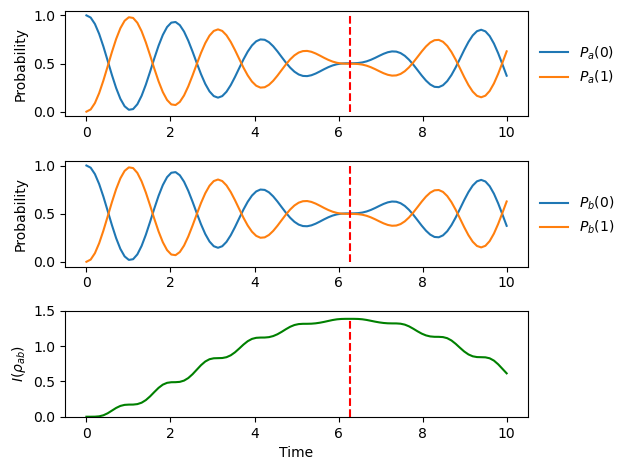

In [6]:
#Evolution of 4 basis states for 2 interdependent systems
n1 = 2
n2 = 2

reduced_density_matrix_a = lambda rho_tensor: np.trace(rho_tensor, axis1=1, axis2=3) #rho_a
reduced_density_matrix_b = lambda rho_tensor: np.trace(rho_tensor, axis1=0, axis2=2) #rho_b

#Let's define some useful matrices
hadamard = (1/np.sqrt(2))*np.array([[1, 1],[1, -1]])
identity = np.array([[1, 0],[0, 1]])

#Let's take the following two Hamiltonians for two independent qubits
hamiltonian_a   = np.array([[0, 1.5],[1.5, 0]])
hamiltonian_b   = np.array([[0, 1.5],[1.5, 0]])
hamiltonian_int = np.matmul(np.kron((1/2)*np.array([[1,0],[0,-1]]), identity), np.kron(identity, (1/2)*np.array([[1,0],[0,-1]])))

eig_values_a, eig_vectors_a = np.linalg.eig(hamiltonian_a)
eig_values_b, eig_vectors_b = np.linalg.eig(hamiltonian_b)
#Now form the kronecker product
hamiltonian_total_indep = np.kron(hamiltonian_a, identity) + np.kron(identity, hamiltonian_b) + hamiltonian_int

#What are the initial states for each system? arr = arr[..., None]
initial_state_a = np.matmul(identity, np.array([[1],[0]]))#eig_vectors_a[:,0].reshape(-1,1))
initial_state_b = np.matmul(identity, np.array([[1],[0]]))#eig_vectors_b[:,0].reshape(-1,1))
#Initial state in combined system
initial_state_total = np.kron(initial_state_a, initial_state_b)

#Define the evolution operator function with hbar = 1
def evolutionOperator(hamiltonian, time):
  return expm(-1j*hamiltonian*time)

#Probability of measuring each state
projector_00 = np.array([[1,0,0,0]])
projector_01 = np.array([[0,1,0,0]])
projector_10 = np.array([[0,0,1,0]])
projector_11 = np.array([[0,0,0,1]])
prob_measure_0_a = lambda state: np.abs(np.matmul(projector_00, state)[0][0])**2 + np.abs(np.matmul(projector_01, state)[0][0])**2
prob_measure_1_a = lambda state: np.abs(np.matmul(projector_10, state)[0][0])**2 + np.abs(np.matmul(projector_11, state)[0][0])**2
prob_measure_0_b = lambda state: np.abs(np.matmul(projector_00, state)[0][0])**2 + np.abs(np.matmul(projector_10, state)[0][0])**2
prob_measure_1_b = lambda state: np.abs(np.matmul(projector_01, state)[0][0])**2 + np.abs(np.matmul(projector_11, state)[0][0])**2

#Von Neumann Entropy
von_neumann_entropy = lambda density_matrix: (-1)*np.trace(np.matmul(density_matrix,logm(density_matrix)))

#Create figure
fig_indep       = plt.figure()
ax_indep_a      = fig_indep.add_subplot(311)
ax_indep_b      = fig_indep.add_subplot(312, sharex=ax_indep_a)
ax_indep_c      = fig_indep.add_subplot(313, sharex=ax_indep_a)
time = np.linspace(0,10,100)

prob_0_a = []
prob_1_a = []
prob_0_b = []
prob_1_b = []

prob_00 = []
prob_01 = []
prob_10 = []
prob_11 = []
entanglement_entropy = []

relative_entropy = []


for current_time in time:
  current_state = np.matmul(evolutionOperator(hamiltonian_total_indep, current_time), initial_state_total)
  if((current_time > 6.2) & (current_time < 6.3)):
    print("Current State: " + str(current_state))
    print("Current Density: " + str(current_state@np.conj(np.transpose(current_state))))
  density_matrix = np.matmul(current_state, np.transpose(np.conjugate(current_state)))
  rho_tensor=density_matrix.reshape([n1, n2, n1, n2]);
  entanglement_entropy.append(von_neumann_entropy(reduced_density_matrix_a(rho_tensor)))
  relative_entropy.append(von_neumann_entropy(reduced_density_matrix_a(rho_tensor)) + von_neumann_entropy(reduced_density_matrix_b(rho_tensor)) - von_neumann_entropy(density_matrix))
  prob_0_a.append(prob_measure_0_a(current_state))
  prob_1_a.append(prob_measure_1_a(current_state))
  prob_0_b.append(prob_measure_0_b(current_state))
  prob_1_b.append(prob_measure_1_b(current_state))
  prob_00.append(np.abs(np.matmul(projector_00, current_state)[0][0])**2)
  prob_01.append(np.abs(np.matmul(projector_01, current_state)[0][0])**2)
  prob_10.append(np.abs(np.matmul(projector_10, current_state)[0][0])**2)
  prob_11.append(np.abs(np.matmul(projector_11, current_state)[0][0])**2)

# Find time when QMI is maximised
max_y = max(np.array(relative_entropy))  # Find the maximum y value
max_x = time[np.array(relative_entropy).argmax()]  # Find the x value corresponding to the maximum y value
print("max_x: " + str(max_x))
print("max_y: " + str(max_y))
max_state = np.matmul(evolutionOperator(hamiltonian_total_indep, max_x), initial_state_total)
print("max_state " + str(max_state))

#(QMI) Relative Entropy = S(rho_a) + S(rho_b) - S(rho_ab)

ax_indep_a.plot(time, prob_0_a, label=r"$P_{a}(0)$")
ax_indep_a.plot(time, prob_1_a, label=r"$P_{a}(1)$")
ax_indep_b.plot(time, prob_0_b, label=r"$P_{b}(0)$")
ax_indep_b.plot(time, prob_1_b, label=r"$P_{b}(1)$")
#ax_indep_a.set_ylim([0,1])

#ax_indep_a.plot(time, prob_00, label="P(00)")
#ax_indep_a.plot(time, prob_01, label="P(01)")
#ax_indep_a.plot(time, prob_10, label="P(10)")
#ax_indep_a.plot(time, prob_11, label="P(11)")
ax_indep_a.legend()
ax_indep_b.legend()
ax_indep_c.plot(time, relative_entropy, color="g")
#ax_indep_c.plot(time, entanglement_entropy)
ax_indep_c.set_ylim([0,1.5])


ax_indep_c.set_xlabel(r"Time")

ax_indep_a.set_ylabel(r"Probability")
ax_indep_b.set_ylabel(r"Probability")
ax_indep_c.set_ylabel(r"$I(\rho_{ab})$")

ax_indep_a.vlines(x=max_x, ymin=0, ymax=1.0, ls="--", color="r")
ax_indep_b.vlines(x=max_x, ymin=0, ymax=1.0, ls="--", color="r")
ax_indep_c.vlines(x=max_x, ymin=0, ymax=max_y, ls="--", color="r")

ax_indep_a.legend(fontsize=10, frameon=False, bbox_to_anchor=(1,0.8))
ax_indep_b.legend(fontsize=10, frameon=False, bbox_to_anchor=(1,0.8))

plt.tight_layout()

fig_indep.patch.set_alpha(0.0)
ax_indep_a.patch.set_alpha(1.0)
ax_indep_b.patch.set_alpha(1.0)
ax_indep_c.patch.set_alpha(1.0)

#plt.savefig("entanglement_qmi.pdf", dpi=300, bbox_inches = "tight")
plt.show()

In [25]:
#Calculating the fidelity to see which Bell state we have or if we need to apply any further rotations
#Can remove global phase as well for the state vector

input_state = np.array([[1/np.sqrt(2)],[0],[0],[-1/np.sqrt(2)]])
#input_state = np.array([[1/np.sqrt(2)],[0],[0],[+1j*1/np.sqrt(2)]])
input_density = input_state@np.conj(np.transpose(input_state))

print(identity)
print(np.array([[1,0],[0,1j]]))
np.kron(identity,np.array([[1,0],[0,1j]]))

# Rotate to find a Bell state
max_state_rotate = np.kron(identity,np.array([[1,0],[0,1j]]))@max_state
max_density = max_state@np.conj(np.transpose(max_state))
print(max_density)

#Given we are working with pure states here I define the fidelity in terms of state vectors
fidelity = np.abs(np.conj(np.transpose(max_state_rotate))@input_state)**2

print(fidelity)

#Confirming the relative entropy is maximised for the Bell state
rho_tensor=input_density.reshape([n1, n2, n1, n2])
von_neumann_entropy(reduced_density_matrix_a(rho_tensor)) + von_neumann_entropy(reduced_density_matrix_b(rho_tensor)) - von_neumann_entropy(input_density)

[[1 0]
 [0 1]]
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+1.j]]

[[ 5.02709979e-01+0.00000000e+00j  8.58679973e-04+8.62852759e-04j
   8.58679973e-04+8.62852759e-04j -2.94771586e-06-4.99989692e-01j]
 [ 8.58679973e-04-8.62852759e-04j  2.94771586e-06+0.00000000e+00j
   2.94771586e-06-1.48975856e-19j -8.58188687e-04-8.54028386e-04j]
 [ 8.58679973e-04-8.62852759e-04j  2.94771586e-06+1.48975856e-19j
   2.94771586e-06+0.00000000e+00j -8.58188687e-04-8.54028386e-04j]
 [-2.94771586e-06+4.99989692e-01j -8.58188687e-04+8.54028386e-04j
  -8.58188687e-04+8.54028386e-04j  4.97284126e-01+0.00000000e+00j]]
[[0.99998674]]


1.3862943611198908